In [7]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
import multiprocessing
import astropy.io.fits as pyfits
from copy import deepcopy
import matplotlib

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [8]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

lens = SampleSkyPyLens()

num_pix = 45
side = 4.95
band = 'f184'

# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'cdm_subhalos_tuple')))

In [3]:
kernel_sca01 = pyfits.getdata(os.path.join(repo_dir, 'mejiro', 'data', 'webbpsf_f184_SCA01.fits'))
kernel_sca09 = pyfits.getdata(os.path.join(repo_dir, 'mejiro', 'data', 'webbpsf_f184_SCA09.fits'))
kernel_sca17 = pyfits.getdata(os.path.join(repo_dir, 'mejiro', 'data', 'webbpsf_f184_SCA17.fits'))

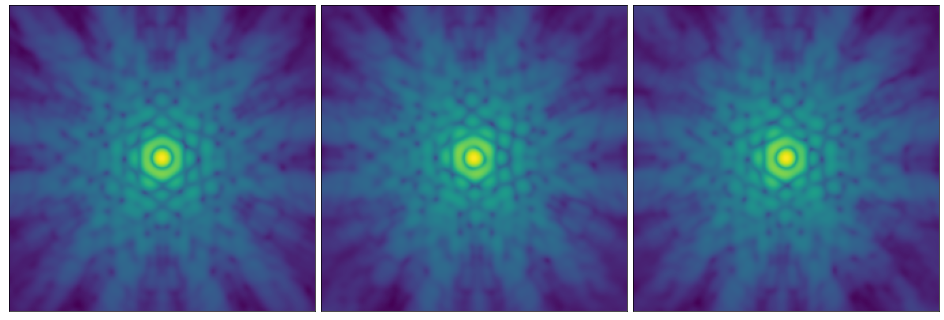

In [4]:
plot.plot_list([np.log10(kernel_sca01), np.log10(kernel_sca09), np.log10(kernel_sca17)])

In [5]:
lens_sca01 = deepcopy(lens)
lens_sca09 = deepcopy(lens)
lens_sca17 = deepcopy(lens)

kwargs_sca01 = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel_sca01,
    'point_source_supersampling_factor': 5
    }

kwargs_sca09 = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel_sca09,
    'point_source_supersampling_factor': 5
    }

kwargs_sca17 = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel_sca17,
    'point_source_supersampling_factor': 5
    }

sca01 = lens_sca01.get_array(num_pix=num_pix, kwargs_psf=kwargs_sca01, side=side)
sca09 = lens_sca09.get_array(num_pix=num_pix, kwargs_psf=kwargs_sca09, side=side)
sca17 = lens_sca17.get_array(num_pix=num_pix, kwargs_psf=kwargs_sca17, side=side)

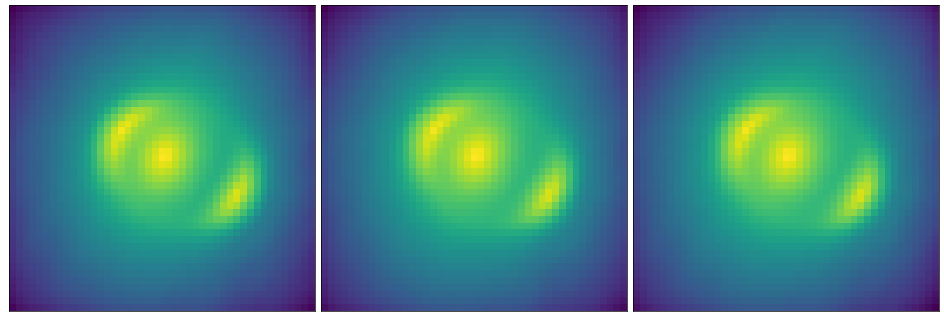

In [6]:
plot.plot_list([np.log10(sca01), np.log10(sca09), np.log10(sca17)])

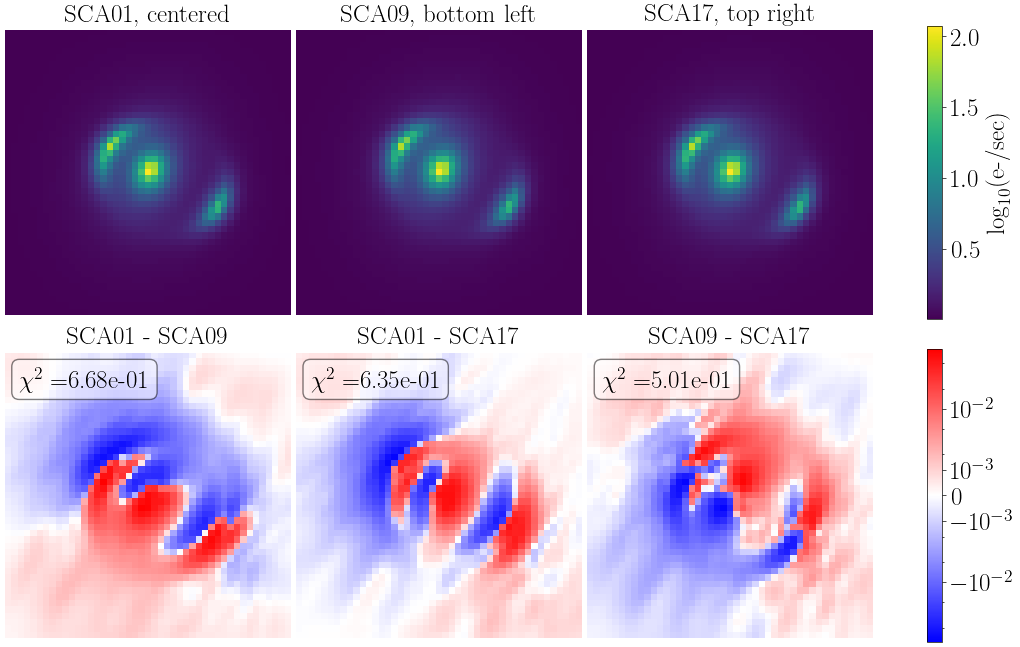

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.02})

fontsize = 18
import matplotlib
matplotlib.rcParams.update({'font.size': fontsize})

array_list = [sca01, sca09, sca17]
title_list = ['SCA01, centered', 'SCA09, bottom left', 'SCA17, top right']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i], fontsize=fontsize)
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('$\log_{10}$(e-/sec)', rotation=90)

array_list = [sca01 - sca09, sca01 - sca17, sca09 - sca17]
title_list = ['SCA01 - SCA09', 'SCA01 - SCA17', 'SCA09 - SCA17']

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(sca01, sca09))
chi_square_list.append(stats.chi_square(sca01, sca17))
chi_square_list.append(stats.chi_square(sca09, sca17))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.001)

for i, array in enumerate(array_list):
    axis_2 = ax[1][i].imshow(array, cmap='bwr', norm=norm)
    ax[1][i].set_title(title_list[i], fontsize=fontsize)
    ax[1][i].set_axis_off()

overplot.text_boxes(ax[1], chi_square_list, fontsize=fontsize)

fig.colorbar(axis_2, ax=ax[1])  # , ticks=[-1, -10** -1, 0, 10 ** -1, 1]

plt.savefig(os.path.join(figure_dir, 'psf_field_dependence.png'))
plt.show()